# Test graph-tool visual tool 
---

In [1]:
"""Import the right packages."""
import os
import sys

import graph_tool.all as gt
import numpy as np

# Get directory first
path = os.getcwd()
par_dir = os.path.abspath(os.path.join(path, ".."))
# Import own module
sys.path.append(par_dir)

if True:
    from simulators.meta_simulator import MetaSimulator
    from simulators.sim_mart_vaq import SimMartVaq
    from utils.plotter import Plotter

/home/louis/.local/share/virtualenvs/criminal_network_analysis-7tqkjw2s/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


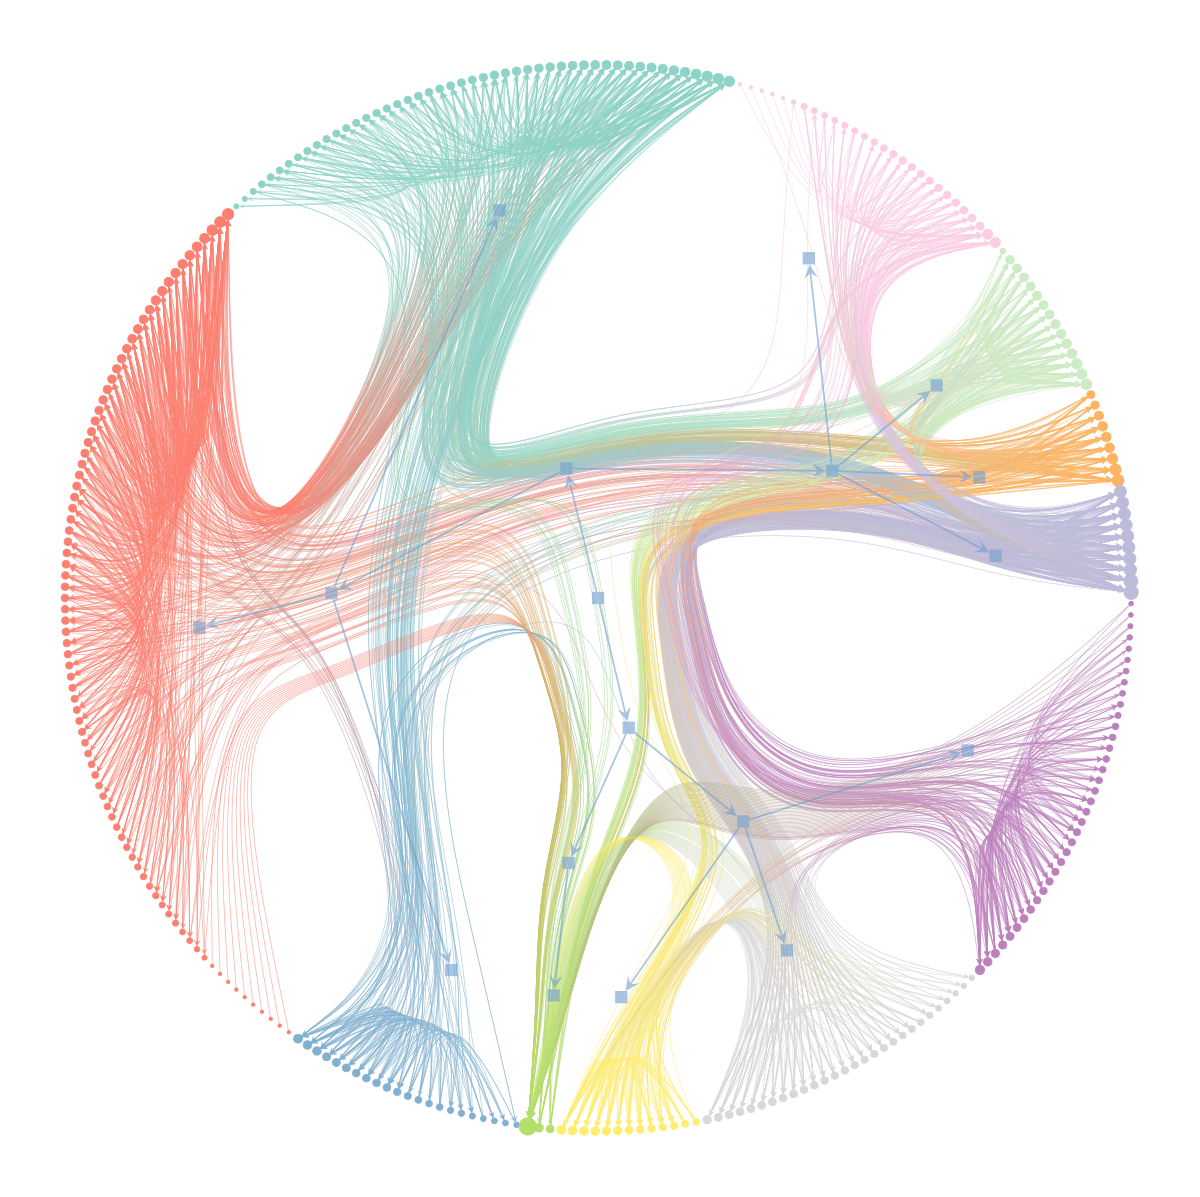

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9d700de520, at 0x7f9d1d241460>,
 <Graph object, directed, with 315 vertices and 314 edges, at 0x7f9d1d23ce80>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9d1d23ce80, at 0x7f9d1d23c970>)

In [2]:
"""Test if resulting graph is shown to prove graph-tool is installed."""

g = gt.collection.data["celegansneural"]
state = gt.minimize_nested_blockmodel_dl(g)
state.draw()

---

Test if random paritions is working.

Thereby it is important to check that the nodes of the same partition do have a connection.

Using OverlapBlockState

group_numbers=frozenset({0, 1, 2, 3})
list(mbr_list)=[1, 2, 0, 0, 2, 3, 1, 1, 0, 0, 1, 2, 1, 1, 3, 0, 1, 0, 3, 1, 1, 2, 1, 0, 2, 0, 3, 2, 2, 3, 0, 0, 3, 0, 0, 1, 2, 3, 0, 3, 0, 2, 3, 0, 2, 0, 2, 1]
list(mbr_list_2[0][0])=[1]


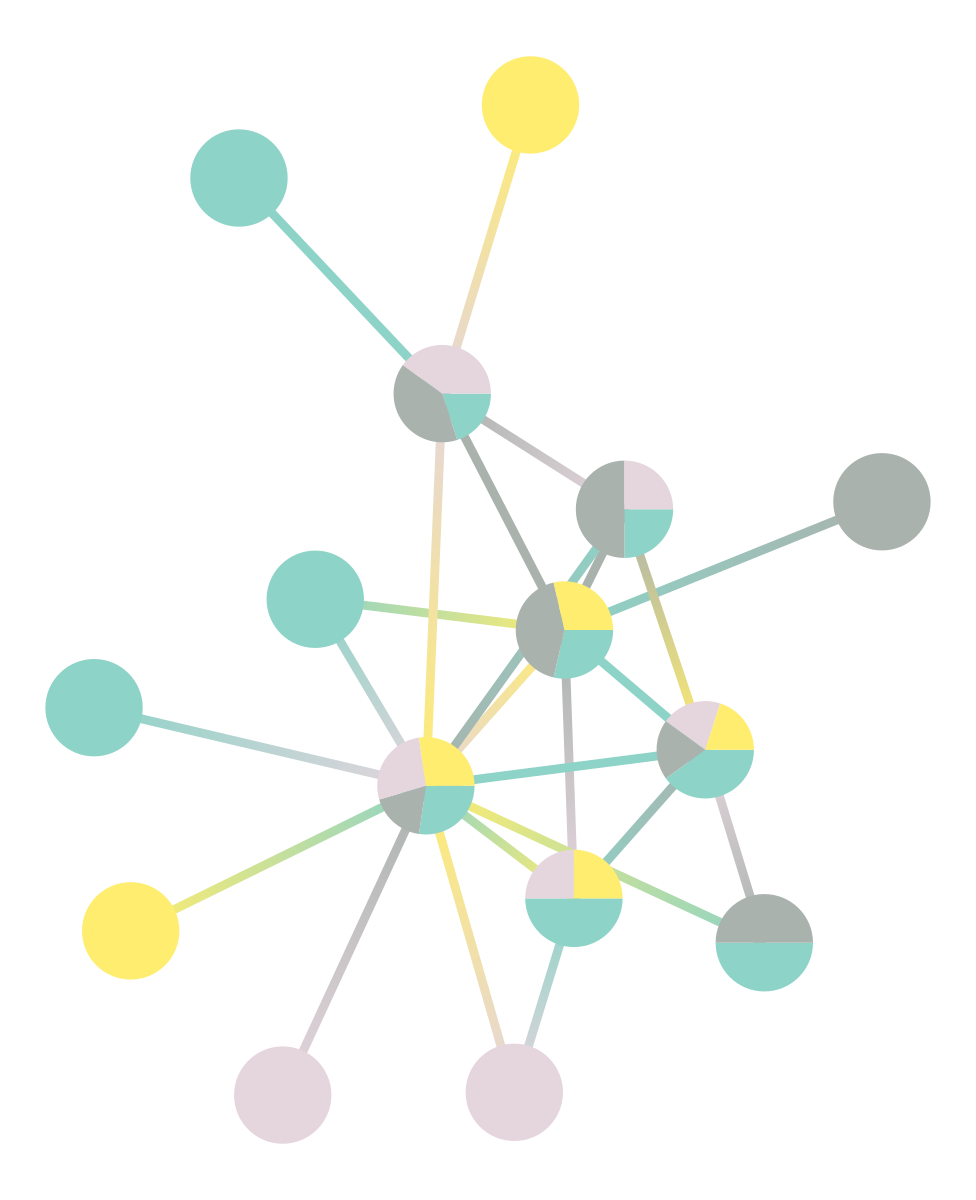

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9d1d2418b0, at 0x7f9d700f8400>

In [3]:
def sample_k(max):
    """Sample number of connections."""
    accept = False
    while not accept:
        k = np.random.randint(1, max + 1)
        accept = np.random.random() < 1.0 / k
    return k


g = gt.random_graph(15, lambda: sample_k(40), directed=False)

partitions = gt.OverlapBlockState(g, B=4)
mbr_list = partitions.get_blocks()
mbr_list_2 = partitions.get_overlap_blocks()
group_numbers = frozenset(mbr_list)
print(f"{group_numbers=}")
print(f"{list(mbr_list)=}")
print(f"{list(mbr_list_2[0][0])=}")
partitions.draw()

group_numbers=frozenset({0})


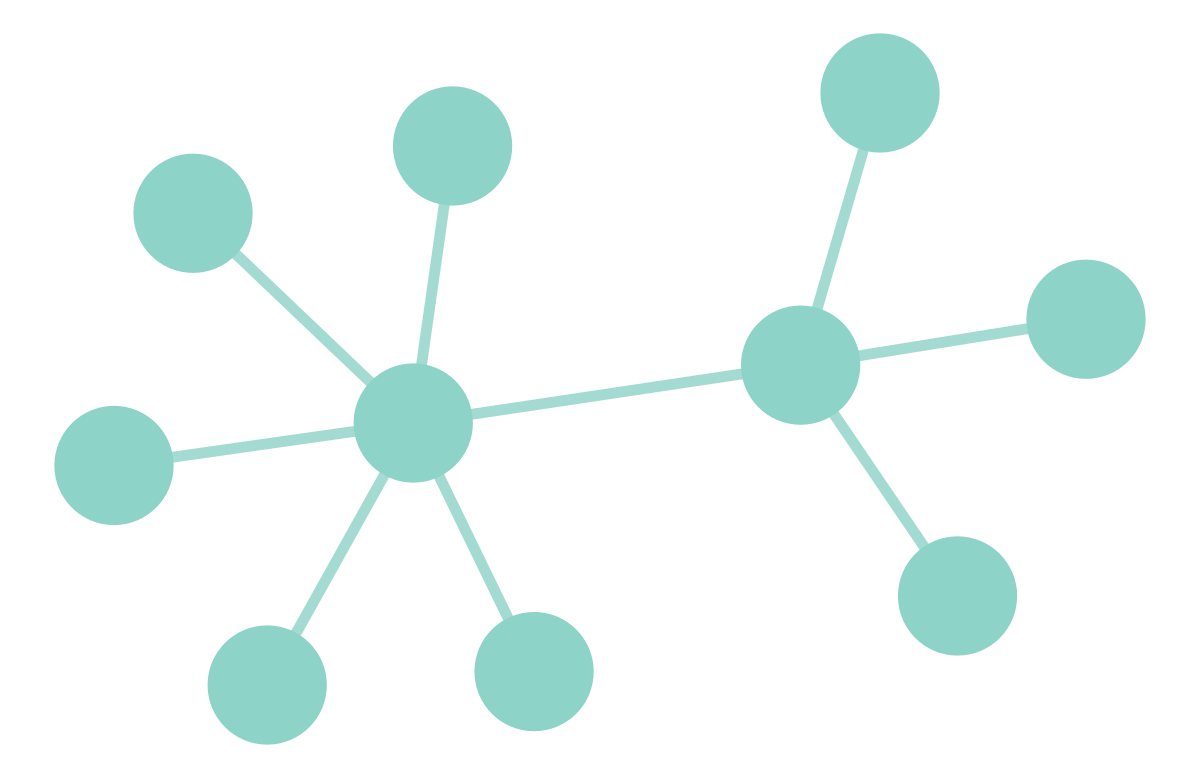

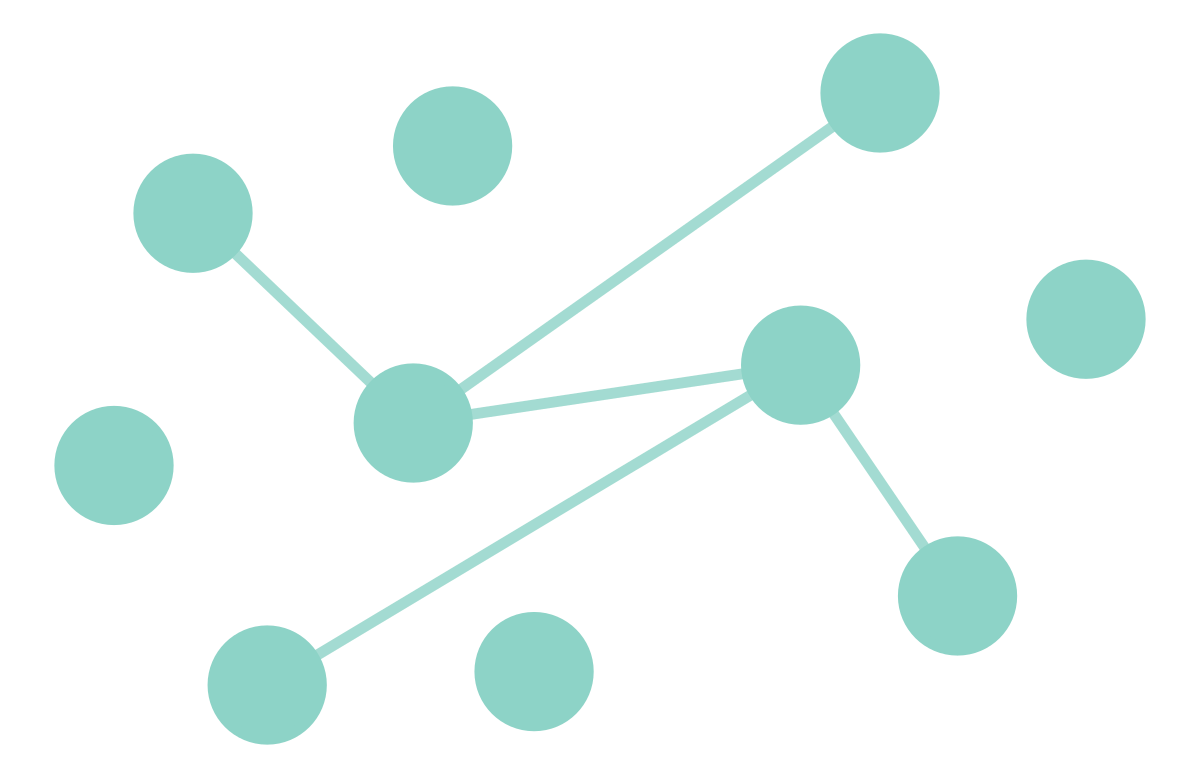

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9d1d25b2e0, at 0x7f9d1d2506a0>

In [4]:
g = gt.price_network(10, m=1, directed=False)
pos = gt.sfdp_layout(g)

partitions = gt.minimize_blockmodel_dl(
    g, multilevel_mcmc_args={"B_min": 0.1 * g.num_vertices()}
)
mbr_list = partitions.get_blocks()
group_numbers = frozenset(mbr_list)
print(f"{group_numbers=}")
partitions.draw(pos=pos)

u = partitions.sample_graph(canonical=True, self_loops=False, multigraph=False)
ustate = gt.BlockState(u, b=partitions.b)
ustate.draw(pos=u.own_property(pos))

--- 
Verify the divide_network function visually

In [5]:
# Speed test
meta_sim = MetaSimulator(
    network_name="montagna_calls", ratio_honest=0.6, ratio_wolf=0.2
)
simulators = SimMartVaq(meta_sim.network)

%timeit simulators.act_divide_in_groups_faster(simulators.network,min_grp=5,max_grp=10)
%timeit simulators.act_divide_in_groups(simulators.network,min_grp=5,max_grp=10)

7.08 ms ± 46.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


  1%|          | 3/475 [00:00<00:02, 233.22it/s]

20.1 ms ± 233 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


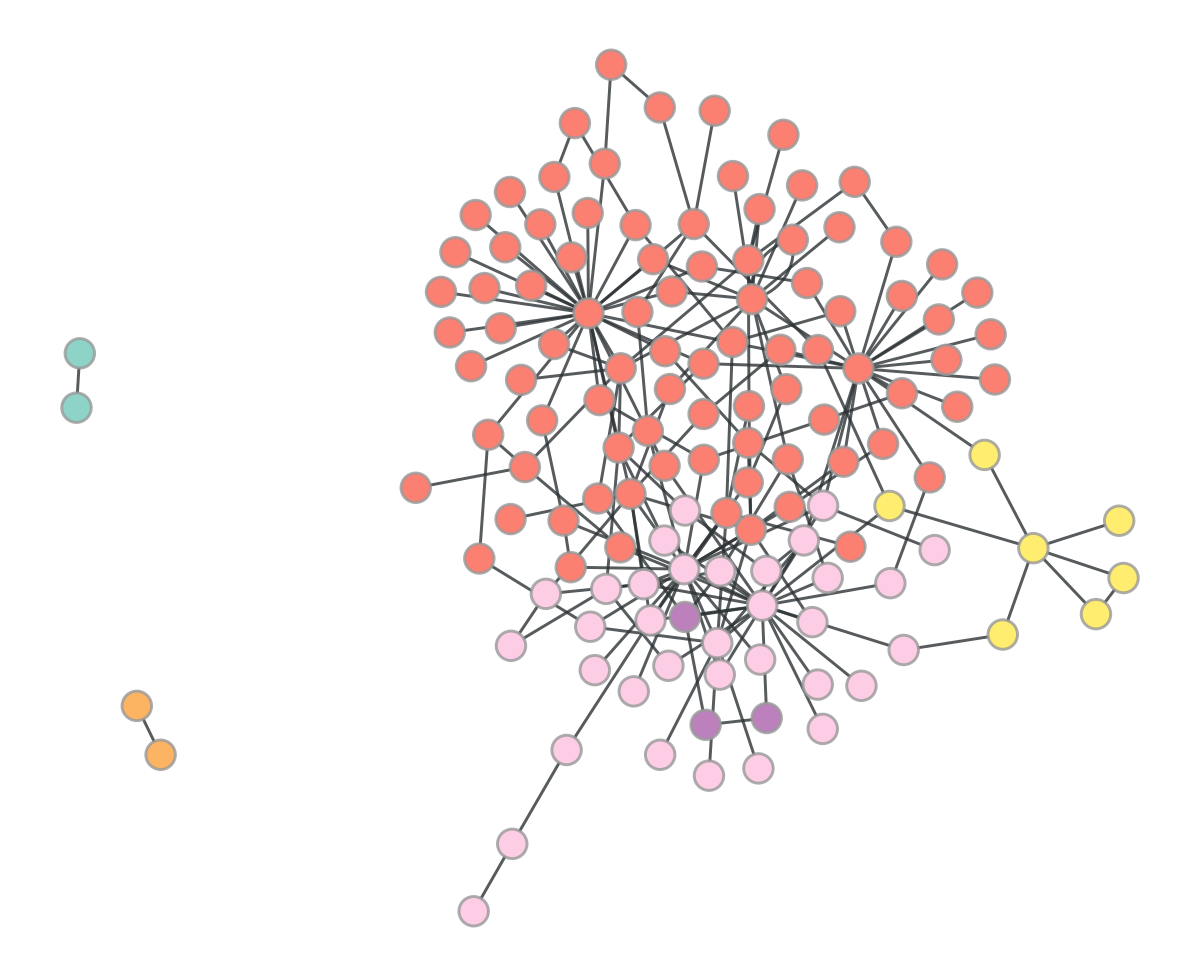

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9d1d250ee0, at 0x7f9d1d1fbee0>

In [6]:
meta_sim = MetaSimulator(
    network_name="montagna_calls", ratio_honest=0.2, ratio_wolf=0.1, n_new_edges=2
)
simulators = SimMartVaq(meta_sim.network)
divided_network, _ = simulators.act_divide_in_groups_faster(
    simulators.network, min_grp=5, max_grp=10
)
pos = gt.sfdp_layout(divided_network)
gt.graph_draw(divided_network, pos=pos, vertex_fill_color=divided_network.vp.grp_nbr)

---
Test if the filtering is working correctly

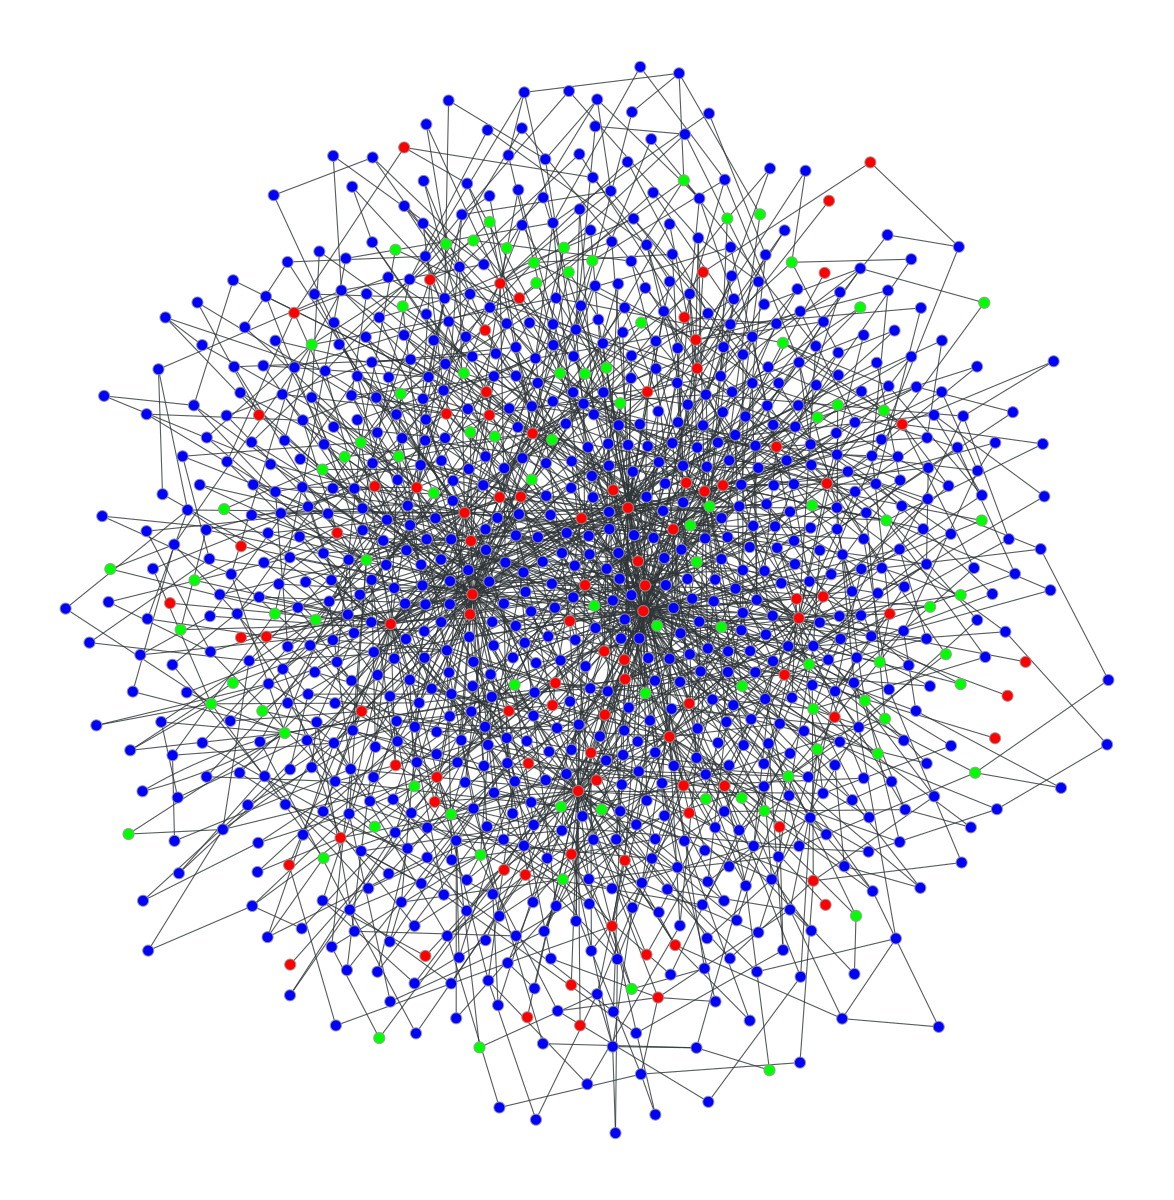

simulators.network.num_vertices()=95


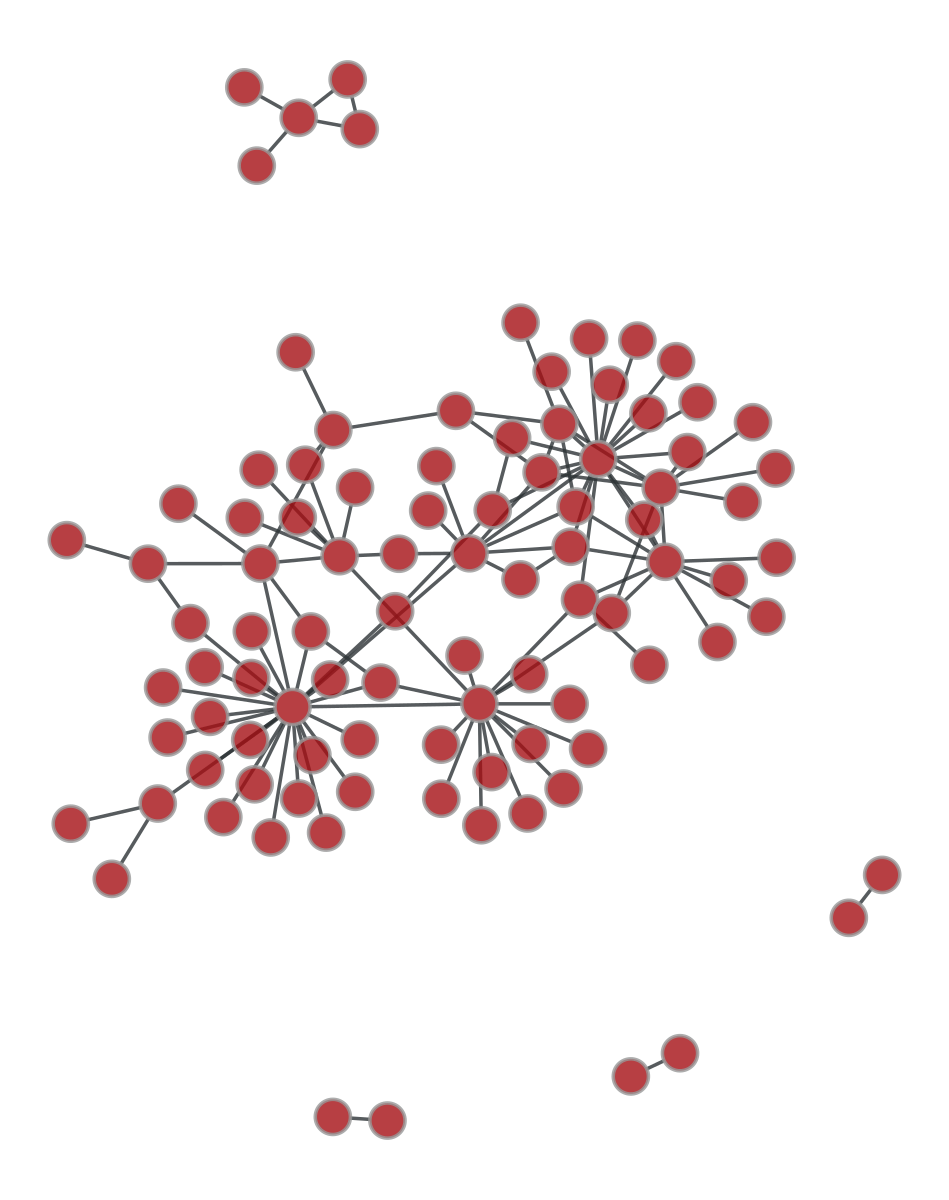

In [7]:
# Adding nodes based on preferential attachment
meta_sim = MetaSimulator(
    network_name="montagna_calls", ratio_honest=0.8, ratio_wolf=0.1, n_new_edges=2
)
simulators = SimMartVaq(meta_sim.network)


plotter = Plotter()
plotter.args.draw_network = "n"
plotter.draw_network(network=simulators.network, color_vertex_property="state_color")


filtering = simulators.network.new_vertex_property("bool")
simulators.network.vertex_properties["filtering"] = filtering
for i in range(0, simulators.network.num_vertices()):
    if simulators.network.vp.state[simulators.network.vertex(i)] == "c":
        simulators.network.vp.filtering[simulators.network.vertex(i)] = 1
    else:
        simulators.network.vp.filtering[simulators.network.vertex(i)] = 0


simulators.network.set_vertex_filter(simulators.network.vp.filtering)
print(f"{simulators.network.num_vertices()=}")
plotter.draw_network(simulators.network)